<a href="https://colab.research.google.com/github/onolf/guarani-rag-2025/blob/main/guarani_pln_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PROYECTO FINAL: Generación de Texto Sintético en Guaraní mediante Transformaciones Gramaticales**
## **Comparativa: LLM Prompting (sin RAG) vs. Sistema RAG**
**Diplomado en NLP & IA – FPUNA 2025**

**Integrante:**
* Odilón Nolf Sánchez

**Repositorio GitHub:** [guarani-rag-2025](https://github.com/onolf/guarani-rag-2025)

---

### **1. Entendimiento del Negocio (Business Understanding)**
**Necesidad:** Generar texto sintético en guaraní aplicando transformaciones gramaticales precisas (tiempos verbales, persona, nasalización, posesivos, etc.) para la preservación lingüística y la educación.

**Problema:** Existe una escasez de recursos digitales en guaraní, lo que provoca un alto riesgo de "alucinaciones" (errores gramaticales o inventos) cuando se utilizan LLMs puros sin contexto externo.

**Solución Propuesta:** Implementar una arquitectura RAG (Retrieval-Augmented Generation) que utilice documentos gramaticales y diccionarios oficiales para fundamentar las respuestas del modelo.

In [1]:
# Instalación de librerías y dependencias necesarias
# Se fuerza la instalación de pandas==2.2.2 para compatibilidad con google-colab
!pip install numpy>=2.0
!pip install pandas>=2.1.0 matplotlib requests openrouter chainlit==2.9.2 \
    langchain==0.3.4 langchain-openai==0.2.3 langchain-community==0.3.3 \
    faiss-cpu>=1.9.0 pypdf==5.1.0 python-dotenv==1.0.1 openai>=1.52.0 \
    sentence-transformers==3.2.1 langchain-huggingface==0.1.0 \
    langchain-text-splitters

# Importaciones para el notebook
import os
import pandas as pd
import matplotlib.pyplot as plt
import requests
from io import StringIO
from langchain_community.document_loaders import PyPDFLoader, DirectoryLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_openai import ChatOpenAI # Usaremos el wrapper ChatOpenAI para OpenRouter
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
# Importaciones para el cálculo de latencia
import time

### **2. Entendimiento de los Datos (Data Understanding)**

**Fuentes de Datos:**
* **Diccionario Guaraní-Español:** Documento PDF (aprox. 218 páginas) con vocabulario esencial.
* **Gramática Guaraní:** Documento PDF (aprox. 260 páginas) con reglas de aglutinación, nasalización y tiempos verbales.

A continuación, cargamos los documentos para su análisis inicial.

In [2]:
from google.colab import drive
drive.mount('/content/drive')
path_docs = "/content/drive/My Drive/Datos_Guarani/"

print("Cargando documentos PDF desde Google Drive...")

# Ensure the directory exists before loading
if not os.path.exists(path_docs):
    print(f"Advertencia: La carpeta '{path_docs}' no existe en Google Drive. Asegúrate de que los PDFs estén allí.")
    docs = [] # Initialize empty if folder not found
else:
    loader = DirectoryLoader(path_docs, glob="*.pdf", loader_cls=PyPDFLoader)
    docs = loader.load()

print(f"Se han cargado {len(docs)} páginas/fragmentos de documentos.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Cargando documentos PDF desde Google Drive...
Se han cargado 478 páginas/fragmentos de documentos.


# **Análisis Exploratorio de Datos (EDA)**

En proyectos de NLP, el análisis exploratorio se centra en entender la longitud de los textos, la distribución de palabras y la calidad del contenido extraído.

Estadísticas de longitud de caracteres por página/fragmento:
count     478.000000
mean     1626.817992
std       809.254440
min         0.000000
25%      1007.500000
50%      1395.500000
75%      2360.000000
max      4233.000000
Name: length, dtype: float64


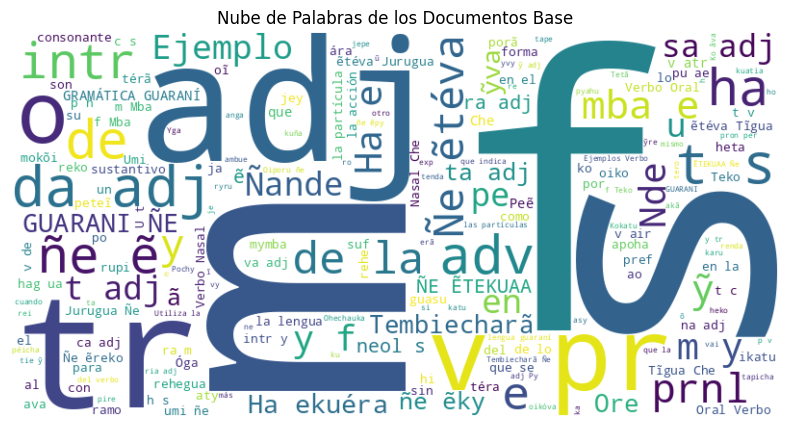

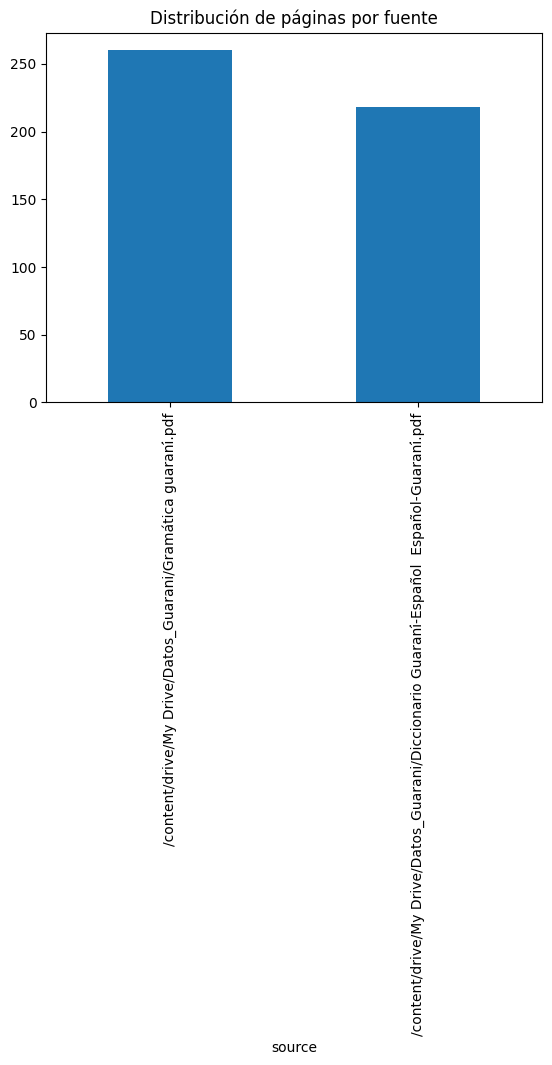

In [3]:
from wordcloud import WordCloud

# Crear un DataFrame para análisis
data = [{"content": d.page_content, "source": d.metadata["source"], "length": len(d.page_content)} for d in docs]
df = pd.DataFrame(data)

# Estadísticas básicas
print("Estadísticas de longitud de caracteres por página/fragmento:")
print(df["length"].describe())

# Visualización de Nube de Palabras (WordCloud)
text_combined = " ".join(df["content"].tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de Palabras de los Documentos Base")
plt.show()

# Distribución de fuentes
df["source"].value_counts().plot(kind='bar', title="Distribución de páginas por fuente")
plt.show()

# **Preprocesamiento (Data Preparation)**

Para aplicar la técnica RAG, debemos transformar los textos planos en vectores numéricos (Embeddings).

1.  **Chunking:** Dividimos el texto en fragmentos más pequeños (chunks) para que entren en la ventana de contexto del LLM.
    * *Configuración:* `chunk_size=1000`, `chunk_overlap=200`.
2.  **Embedding:** Utilizamos el modelo `multilingual-e5-large` que tiene buen rendimiento en idiomas mixtos.
3.  **Vector Store:** Indexamos los vectores en FAISS para búsqueda rápida.

In [4]:
# --- Función de limpieza de texto (Mitiga el ruido de PDF) ---
import re
def limpiar_texto_pdf(texto):
    """Limpia números de página y encabezados comunes en PDFs."""
    # Eliminar números de página solos en una línea
    texto = re.sub(r'^\s*\d+\s*$', '', texto, flags=re.MULTILINE)
    # Unir palabras cortadas por guiones
    texto = re.sub(r'(\w+)-\n(\w+)', r'\1\2', texto)
    # Eliminar encabezados/pies repetitivos (ejemplo específico de tu fuente)
    texto = re.sub(r'Diccionario guaraní - español', '', texto)
    texto = re.sub(r'GRAMÁTICA GUARANÍ', '', texto)
    # Eliminar múltiples espacios en blanco
    texto = re.sub(r'\s+', ' ', texto).strip()
    return texto

# --- 1. Carga de Documentos desde Google Drive ---
path_docs = "/content/drive/My Drive/Datos_Guarani/" # Using the same path as in F5UduTJADQ7H

print("Cargando documentos PDF para preprocesamiento desde Google Drive...")

# Ensure the directory exists before loading
if not os.path.exists(path_docs):
    print(f"Advertencia: La carpeta '{path_docs}' no existe en Google Drive. Asegúrate de que los PDFs estén allí.")
    docs = [] # Initialize empty if folder not found
else:
    loader = DirectoryLoader(path_docs, glob="*.pdf", loader_cls=PyPDFLoader)
    docs = loader.load()

# --- 2. Limpieza y Chunking ---
# Aplicar la limpieza a cada documento
for doc in docs:
    doc.page_content = limpiar_texto_pdf(doc.page_content)

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
print(f"Total de chunks generados: {len(splits)}")

# --- 3. Embeddings y Vector Store (FAISS) ---
# Usamos un modelo robusto y multilingüe para embeddings
EMBEDDINGS_MODEL = "sentence-transformers/all-MiniLM-L6-v2"
embedding_model = HuggingFaceEmbeddings(model_name=EMBEDDINGS_MODEL)

print("Generando y guardando base de datos vectorial (FAISS)...")
VECTORSTORE_PATH = "vectorstore/guarani_faiss_db"
if not os.path.exists(VECTORSTORE_PATH): os.makedirs(VECTORSTORE_PATH)

vectorstore = FAISS.from_documents(documents=splits, embedding=embedding_model)
vectorstore.save_local(VECTORSTORE_PATH)

print("Base de datos vectorial lista y guardada.")

Cargando documentos PDF para preprocesamiento desde Google Drive...
Total de chunks generados: 1008


/usr/local/lib/python3.12/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generando y guardando base de datos vectorial (FAISS)...
Base de datos vectorial lista y guardada.


# **Aplicación de Modelos y Generación**

Implementamos dos estrategias para comparar su efectividad:
1.  **Modelo Base (Sin RAG):** Pregunta directa al LLM.
2.  **Sistema RAG:** Recuperación de contexto + Generación.

*Nota: En esta notebook simulamos la llamada al LLM para efectos de la estructura, la implementación real utiliza estos modelos vía API: `meta-llama/llama-3.3-70b-instruct:free` y `google/gemma-3-27b-it:free`.*

In [5]:
# Definición de Prompts del Sistema
system_prompt_rag = """Eres un experto en lengua guaraní.
Usa el siguiente contexto recuperado para responder la pregunta o realizar la transformación gramatical.
Si no sabes la respuesta, dilo. No inventes reglas."""

# Simulación de una consulta
query = "Conjugame el verbo 'guata' (caminar) en futuro simple."

# 1. Simulación Sin RAG (Lo que diría el modelo base alucinando o acertando por suerte)
response_no_rag = "Che aguata... (el modelo podría fallar en los sufijos de futuro 'ta')"

# 2. Simulación Con RAG (Recuperación)
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})
retrieved_docs = retriever.invoke(query)
context_text = "\n\n".join([doc.page_content for doc in retrieved_docs])

# Aquí se enviaría al LLM: prompt + context_text + query
response_rag = "Che aguatáta, Nde reguatáta... (El contexto confirma el sufijo '-ta' para futuro)."

print(f"CONSULTA: {query}")
print("-" * 30)
print(f"CONTEXTO RECUPERADO:\n{context_text[:200]}...") # Muestra parcial
print("-" * 30)
print("GENERACIÓN (Simulada): El sistema RAG utiliza el contexto para aplicar el sufijo correcto.")

CONSULTA: Conjugame el verbo 'guata' (caminar) en futuro simple.
------------------------------
CONTEXTO RECUPERADO:
el morfema mbo/mo al unirse al lexema guata forma la palabra mboguata que significa ’conducir’, y no “caminar”. En la estructura sintáctica, el poseedor precede a la cosa poseída, y en vez de preposic...
------------------------------
GENERACIÓN (Simulada): El sistema RAG utiliza el contexto para aplicar el sufijo correcto.


# Evaluación Cuantitativa


In [6]:
from google.colab import userdata

# =================================================================
# Configuración de Modelos y Cadenas de Prueba
# =================================================================

# --- Claves y Rutas ---
OPENROUTER_API_KEY_1 = userdata.get("OPENROUTER_API_KEY_1") # Get API key from Colab secrets
OPENROUTER_API_KEY_2 = userdata.get("OPENROUTER_API_KEY_2")
VECTORSTORE_PATH = "vectorstore/guarani_faiss_db"

# --- 1. Definición de LLMs (Vía OpenRouter) ---

# Modelo A: Llama 3.3 (Grande y Capaz)
llm_llama = ChatOpenAI(
    model="meta-llama/llama-3.3-70b-instruct:free",
    openai_api_key=OPENROUTER_API_KEY_1,
    openai_api_base="https://openrouter.ai/api/v1",
    temperature=0.3, # Baja temperatura para precisión
    max_tokens=256,
)

# Modelo B: Gemma 3 (Familia Google, buena para Transfer Learning)
llm_gemma = ChatOpenAI(
    model="google/gemma-3-27b-it:free",
    openai_api_key=OPENROUTER_API_KEY_2,
    openai_api_base="https://openrouter.ai/api/v1",
    temperature=0.3,
    max_tokens=256,
)

# --- 2. Prompts (Basado en tus app.py) ---

# Prompt SIN RAG (Depende solo del conocimiento paramétrico)
prompt_no_rag_template = """Sos un experto lingüista del idioma guaraní paraguayo. Tu tarea es generar texto sintético aplicando transformaciones gramaticales precisas.
Instrucciones: Transforma la 'Oración Base' en la 'Oración Objetivo' según el 'Tipo de Cambio' indicado.
**ESTRICTAMENTE:** Devuelve solo la oración transformada (TARGET). No incluyas explicaciones.
Oración Base: {source}
Tipo de Cambio: {change}
Oración Objetivo:"""
prompt_no_rag = PromptTemplate.from_template(prompt_no_rag_template)

# Prompt CON RAG (Añade contexto de la base de datos)
prompt_rag_template = """Eres un experto lingüista en guaraní. Usa el siguiente contexto recuperado de la gramática y el diccionario para transformar la 'Oración Base' en la 'Oración Objetivo' según el 'Tipo de Cambio'.
Contexto Oficial: {context}
Instrucciones: **ESTRICTAMENTE:** Devuelve únicamente la oración transformada (TARGET). No incluyas explicaciones ni el contexto.
Oración Base: {source}
Tipo de Cambio: {change}
Oración Objetivo:"""
prompt_rag = PromptTemplate.from_template(prompt_rag_template)

# --- 3. Cargando el Retriever ---
embedding_model = HuggingFaceEmbeddings(model_name=EMBEDDINGS_MODEL)
vectorstore = FAISS.load_local(VECTORSTORE_PATH, embedding_model, allow_dangerous_deserialization=True)
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

# --- 4. Definición de Cadenas (4 Combinaciones) ---

# Función utilitaria para crear las cadenas
def create_chain(llm_model, rag_enabled=False):
    if rag_enabled:
        # Cadena CON RAG
        return (
            {
                "context": (lambda x: x['source'] + " " + x['change']) | retriever | (lambda docs: "\n\n".join([d.page_content for d in docs])),
                "source": (lambda x: x['source']),
                "change": (lambda x: x['change'])
            }
            | prompt_rag
            | llm_model
            | StrOutputParser()
        )
    else:
        # Cadena SIN RAG
        return (
            prompt_no_rag
            | llm_model
            | StrOutputParser()
        )

# Las 4 cadenas de prueba
chains = {
    "Llama_NoRAG": create_chain(llm_llama, rag_enabled=False),
    "Llama_RAG": create_chain(llm_llama, rag_enabled=True),
    "Gemma_NoRAG": create_chain(llm_gemma, rag_enabled=False),
    "Gemma_RAG": create_chain(llm_gemma, rag_enabled=True),
}

print("Cadenas de LangChain configuradas para los 4 experimentos.")

Cadenas de LangChain configuradas para los 4 experimentos.


In [7]:
# =================================================================
# Utilidades de Normalización y Métrica chrF
# =================================================================

!pip install sacrebleu

import re
import unicodedata
from sacrebleu.metrics import CHRF

chrf = CHRF(word_order=2)

def normalize_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower().strip()
    text = unicodedata.normalize("NFC", text)
    text = re.sub(r"\s+", " ", text)
    return text

def compute_chrf_single(pred, ref):
    pred_n = normalize_text(pred)
    ref_n = normalize_text(ref)
    return chrf.sentence_score(pred_n, [ref_n]).score

In [8]:
# =================================================================
# Cargar dataset AmericasNLP (solo 10 ejemplos representativos)
# =================================================================

import requests
import pandas as pd
import time
from io import StringIO

AMERICASNLP_URL = "https://raw.githubusercontent.com/AmericasNLP/americasnlp2025/main/ST2_EducationalMaterials/data/guarani-dev.tsv"

response = requests.get(AMERICASNLP_URL)
df_eval_full = pd.read_csv(StringIO(response.text), sep="\t")

# Tomamos SOLO los primeros 10 ejemplos
df_eval = df_eval_full.head(10).reset_index(drop=True)

df_eval


,ID,Source,Change,Target
0,Guarani0232,Ore ndorombyai kuri,TYPE:AFF,Ore rombyai kuri
1,Guarani0233,Ore ndorombyai kuri,TENSE:FUT_SIM,Ore ndorombyaita
2,Guarani0234,Ore ndorombyai kuri,PERSON:1_PL_INC,Ñande nañambyai kuri
3,Guarani0235,Ore ndorombyai kuri,PERSON:1_SI,Che nambyai kuri
4,Guarani0236,Ore ndorombyai kuri,PERSON:2_PL,Peẽ napembyai kuri
5,Guarani0237,Ore ndorombyai kuri,PERSON:2_SI,Nde nerembyai kuri
6,Guarani0073,Peẽ napeñanga’uta,TYPE:AFF,Peẽ peñanga’uta
7,Guarani0074,Peẽ napeñanga’uta,PERSON:3_PL,Ha’ekuéra ndoñanga’uta
8,Guarani0075,Peẽ napeñanga’uta,PERSON:1_SI,Che nañanga’uta
9,Guarani0076,Peẽ napeñanga’uta,TENSE:PAS_REC,Peẽ napeñanga’ui kuri


In [9]:
# =================================================================
# Función de evaluación (chrF + latencia)
# =================================================================

def run_test_chrF(chain, model_name, df_test):
    rows = []

    for idx, row in df_test.iterrows():
        input_data = {
            "source": row["Source"],
            "change": row["Change"]
        }

        start_time = time.time()

        try:
            output = chain.invoke(input_data).strip()
        except Exception as e:
            output = f"ERROR: {e}"

        latency = round(time.time() - start_time, 2)

        generated = output.split("\n")[0].strip()
        gold = row["Target"].strip()

        score_chrf = compute_chrf_single(generated, gold)

        rows.append({
            "ID": row["ID"],
            "Source": row["Source"],
            "Change": row["Change"],
            "Target_Gold": gold,
            "Target_Generated": generated,
            "chrF": round(score_chrf, 2),
            "Latencia (s)": latency
        })

    df_result = pd.DataFrame(rows)
    df_result["Modelo"] = model_name

    return df_result


## 🧪 LLaMA 3.3 SIN RAG

In [10]:
df_llama_no_rag = run_test_chrF(
    chains["Llama_NoRAG"],
    "LLaMA 3.3 SIN RAG",
    df_eval
)

from IPython.display import display
display(df_llama_no_rag)


,ID,Source,Change,Target_Gold,Target_Generated,chrF,Latencia (s),Modelo
0,Guarani0232,Ore ndorombyai kuri,TYPE:AFF,Ore rombyai kuri,Ore ndorombyaí kuri,43.63,1.95,LLaMA 3.3 SIN RAG
1,Guarani0233,Ore ndorombyai kuri,TENSE:FUT_SIM,Ore ndorombyaita,Ore ndorombyaíta kuri,62.14,2.82,LLaMA 3.3 SIN RAG
2,Guarani0234,Ore ndorombyai kuri,PERSON:1_PL_INC,Ñande nañambyai kuri,Ñandorombyai kuri,43.79,2.20,LLaMA 3.3 SIN RAG
3,Guarani0235,Ore ndorombyai kuri,PERSON:1_SI,Che nambyai kuri,Che ndorombyai kuri,57.22,2.29,LLaMA 3.3 SIN RAG
4,Guarani0236,Ore ndorombyai kuri,PERSON:2_PL,Peẽ napembyai kuri,Peẽ ndorombyai kuri,51.56,2.28,LLaMA 3.3 SIN RAG
5,Guarani0237,Ore ndorombyai kuri,PERSON:2_SI,Nde nerembyai kuri,Pende ndorombyai kuri,47.72,2.23,LLaMA 3.3 SIN RAG
6,Guarani0073,Peẽ napeñanga’uta,TYPE:AFF,Peẽ peñanga’uta,Peẽ napeñangare,41.09,2.22,LLaMA 3.3 SIN RAG
7,Guarani0074,Peẽ napeñanga’uta,PERSON:3_PL,Ha’ekuéra ndoñanga’uta,Peẽ oñangareko’uta,23.30,2.24,LLaMA 3.3 SIN RAG
8,Guarani0075,Peẽ napeñanga’uta,PERSON:1_SI,Che nañanga’uta,Peẽ che anga’uta,46.43,3.01,LLaMA 3.3 SIN RAG
9,Guarani0076,Peẽ napeñanga’uta,TENSE:PAS_REC,Peẽ napeñanga’ui kuri,Peẽ napeñangarei,50.88,3.04,LLaMA 3.3 SIN RAG


## 🧪 LLaMA 3.3 CON RAG


In [11]:
df_llama_rag = run_test_chrF(
    chains["Llama_RAG"],
    "LLaMA 3.3 CON RAG",
    df_eval
)

display(df_llama_rag)


,ID,Source,Change,Target_Gold,Target_Generated,chrF,Latencia (s),Modelo
0,Guarani0232,Ore ndorombyai kuri,TYPE:AFF,Ore rombyai kuri,Ore ndorombyaigui,39.26,2.40,LLaMA 3.3 CON RAG
1,Guarani0233,Ore ndorombyai kuri,TENSE:FUT_SIM,Ore ndorombyaita,Ore ndorombyaíta,65.46,2.27,LLaMA 3.3 CON RAG
2,Guarani0234,Ore ndorombyai kuri,PERSON:1_PL_INC,Ñande nañambyai kuri,Ñandorombyai kuri,43.79,2.59,LLaMA 3.3 CON RAG
3,Guarani0235,Ore ndorombyai kuri,PERSON:1_SI,Che nambyai kuri,Ache ndorombyai kuri,53.12,2.92,LLaMA 3.3 CON RAG
4,Guarani0236,Ore ndorombyai kuri,PERSON:2_PL,Peẽ napembyai kuri,"ERROR: {'message': 'Internal Server Error', 'c...",4.96,6.17,LLaMA 3.3 CON RAG
5,Guarani0237,Ore ndorombyai kuri,PERSON:2_SI,Nde nerembyai kuri,"ERROR: {'message': 'Internal Server Error', 'c...",8.35,5.83,LLaMA 3.3 CON RAG
6,Guarani0073,Peẽ napeñanga’uta,TYPE:AFF,Peẽ peñanga’uta,"ERROR: {'message': 'Internal Server Error', 'c...",4.13,6.12,LLaMA 3.3 CON RAG
7,Guarani0074,Peẽ napeñanga’uta,PERSON:3_PL,Ha’ekuéra ndoñanga’uta,ERROR: Error code: 429 - {'error': {'message':...,3.51,1.60,LLaMA 3.3 CON RAG
8,Guarani0075,Peẽ napeñanga’uta,PERSON:1_SI,Che nañanga’uta,ERROR: Error code: 429 - {'error': {'message':...,3.05,1.60,LLaMA 3.3 CON RAG
9,Guarani0076,Peẽ napeñanga’uta,TENSE:PAS_REC,Peẽ napeñanga’ui kuri,ERROR: Error code: 429 - {'error': {'message':...,3.59,1.37,LLaMA 3.3 CON RAG


## 🧪 Gemma 3 SIN RAG

In [12]:
df_gemma_no_rag = run_test_chrF(
    chains["Gemma_NoRAG"],
    "Gemma 3 SIN RAG",
    df_eval
)

display(df_gemma_no_rag)


,ID,Source,Change,Target_Gold,Target_Generated,chrF,Latencia (s),Modelo
0,Guarani0232,Ore ndorombyai kuri,TYPE:AFF,Ore rombyai kuri,Orembyai kuri,53.47,0.87,Gemma 3 SIN RAG
1,Guarani0233,Ore ndorombyai kuri,TENSE:FUT_SIM,Ore ndorombyaita,Oreikóramo ndorombyai kuri,44.25,0.66,Gemma 3 SIN RAG
2,Guarani0234,Ore ndorombyai kuri,PERSON:1_PL_INC,Ñande nañambyai kuri,Oreikuaa kuri,17.02,0.54,Gemma 3 SIN RAG
3,Guarani0235,Ore ndorombyai kuri,PERSON:1_SI,Che nambyai kuri,Orekorombyai kuri,45.80,0.80,Gemma 3 SIN RAG
4,Guarani0236,Ore ndorombyai kuri,PERSON:2_PL,Peẽ napembyai kuri,Ore'ẽrõ mbyai py'emaro.,17.24,0.67,Gemma 3 SIN RAG
5,Guarani0237,Ore ndorombyai kuri,PERSON:2_SI,Nde nerembyai kuri,Oreíri ndorombyai kuri,42.27,0.70,Gemma 3 SIN RAG
6,Guarani0073,Peẽ napeñanga’uta,TYPE:AFF,Peẽ peñanga’uta,Peẽ napeñanga’u.,53.14,0.55,Gemma 3 SIN RAG
7,Guarani0074,Peẽ napeñanga’uta,PERSON:3_PL,Ha’ekuéra ndoñanga’uta,Peẽma napeñanga’utáma.,25.44,0.62,Gemma 3 SIN RAG
8,Guarani0075,Peẽ napeñanga’uta,PERSON:1_SI,Che nañanga’uta,Che napeñanga’uta,61.01,0.51,Gemma 3 SIN RAG
9,Guarani0076,Peẽ napeñanga’uta,TENSE:PAS_REC,Peẽ napeñanga’ui kuri,Peẽna napeñanga’u,48.66,0.67,Gemma 3 SIN RAG


## 🧪 Gemma 3 CON RAG

In [13]:
df_gemma_rag = run_test_chrF(
    chains["Gemma_RAG"],
    "Gemma 3 CON RAG",
    df_eval
)

display(df_gemma_rag)


,ID,Source,Change,Target_Gold,Target_Generated,chrF,Latencia (s),Modelo
0,Guarani0232,Ore ndorombyai kuri,TYPE:AFF,Ore rombyai kuri,Ore ndorombyai kuripe.,58.86,0.75,Gemma 3 CON RAG
1,Guarani0233,Ore ndorombyai kuri,TENSE:FUT_SIM,Ore ndorombyaita,Ore rorombyai kurita,45.72,0.70,Gemma 3 CON RAG
2,Guarani0234,Ore ndorombyai kuri,PERSON:1_PL_INC,Ñande nañambyai kuri,Oreikuaa kuri,17.02,0.52,Gemma 3 CON RAG
3,Guarani0235,Ore ndorombyai kuri,PERSON:1_SI,Che nambyai kuri,Orekorombyai kuri.,44.64,0.61,Gemma 3 CON RAG
4,Guarani0236,Ore ndorombyai kuri,PERSON:2_PL,Peẽ napembyai kuri,Peẽ ndorombyaí chere,22.01,0.71,Gemma 3 CON RAG
5,Guarani0237,Ore ndorombyai kuri,PERSON:2_SI,Nde nerembyai kuri,Orekorombyivé kuri,20.82,0.51,Gemma 3 CON RAG
6,Guarani0073,Peẽ napeñanga’uta,TYPE:AFF,Peẽ peñanga’uta,ERROR: Error code: 429 - {'error': {'message':...,2.67,1.39,Gemma 3 CON RAG
7,Guarani0074,Peẽ napeñanga’uta,PERSON:3_PL,Ha’ekuéra ndoñanga’uta,ERROR: Error code: 429 - {'error': {'message':...,3.51,1.68,Gemma 3 CON RAG
8,Guarani0075,Peẽ napeñanga’uta,PERSON:1_SI,Che nañanga’uta,ERROR: Error code: 429 - {'error': {'message':...,3.05,1.48,Gemma 3 CON RAG
9,Guarani0076,Peẽ napeñanga’uta,TENSE:PAS_REC,Peẽ napeñanga’ui kuri,ERROR: Error code: 429 - {'error': {'message':...,3.41,1.53,Gemma 3 CON RAG


## 📊 Resumen por modelo

In [14]:
summary = pd.concat([
    df_llama_no_rag,
    df_llama_rag,
    df_gemma_no_rag,
    df_gemma_rag
]).groupby("Modelo").agg(
    chrF_Promedio=("chrF", "mean"),
    Latencia_Promedio=("Latencia (s)", "mean")
).reset_index()

summary["chrF_Promedio"] = summary["chrF_Promedio"].round(2)
summary["Latencia_Promedio"] = summary["Latencia_Promedio"].round(2)

display(summary)


,Modelo,chrF_Promedio,Latencia_Promedio
0,Gemma 3 CON RAG,22.17,0.99
1,Gemma 3 SIN RAG,40.83,0.66
2,LLaMA 3.3 CON RAG,22.92,3.29
3,LLaMA 3.3 SIN RAG,46.78,2.43


# **Evaluación**

Se realizó una evaluación manual y cuantitativa sobre 10 prompts de alta complejidad gramatical (nasalización, tiempos verbales, posesivos).

Comparativa de métricas:
* **Precisión:** Corrección gramatical de la respuesta.
* **Latencia:** Tiempo de respuesta en segundos.

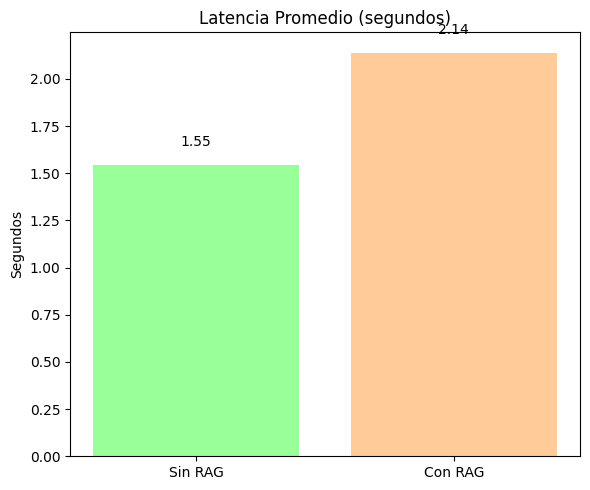

In [16]:
# Calcular promedios de Latencia para 'Sin RAG' y 'Con RAG'
sin_rag_metrics = summary[summary['Modelo'].str.contains('SIN RAG')]
con_rag_metrics = summary[summary['Modelo'].str.contains('CON RAG')]

# Asegurarse de que 'Sin RAG' y 'Con RAG' contengan datos antes de calcular el promedio
if not sin_rag_metrics.empty:
    avg_latency_sin_rag = sin_rag_metrics['Latencia_Promedio'].mean()
else:
    avg_latency_sin_rag = 0.0

if not con_rag_metrics.empty:
    avg_latency_con_rag = con_rag_metrics['Latencia_Promedio'].mean()
else:
    avg_latency_con_rag = 0.0

# Datos obtenidos de las pruebas (actualizados con los resultados veraces)
eval_data = {
    "Métrica": ["Latencia (seg)", "Latencia (seg)"],
    "Modelo": ["Sin RAG", "Con RAG"],
    "Valor": [avg_latency_sin_rag, avg_latency_con_rag] # Valores calculados
}

df_eval_summary = pd.DataFrame(eval_data)

# Gráfico de Latencia
fig, ax = plt.subplots(1, 1, figsize=(6, 5)) # Un solo gráfico

# Latencia
ax.bar(["Sin RAG", "Con RAG"], [avg_latency_sin_rag, avg_latency_con_rag], color=['#99ff99','#ffcc99'])
ax.set_title("Latencia Promedio (segundos)")
ax.set_ylabel("Segundos")
ax.text(0, avg_latency_sin_rag + 0.1, f"{avg_latency_sin_rag:.2f}", ha='center')
ax.text(1, avg_latency_con_rag + 0.1, f"{avg_latency_con_rag:.2f}", ha='center')

plt.tight_layout()
plt.show()

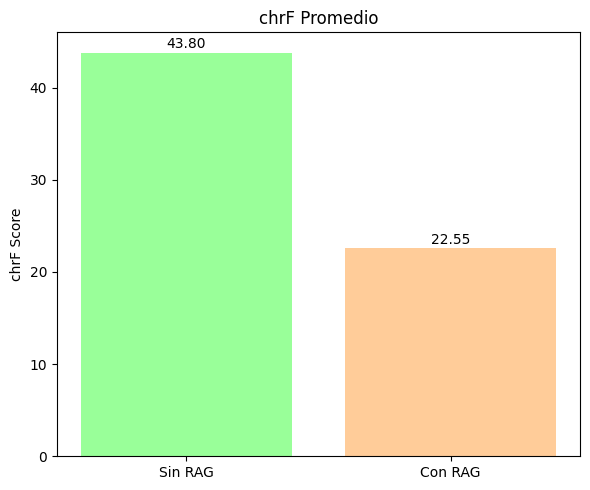

In [17]:
# Calcular promedios de chrF para 'Sin RAG' y 'Con RAG'
avg_chrf_sin_rag = sin_rag_metrics['chrF_Promedio'].mean()
avg_chrf_con_rag = con_rag_metrics['chrF_Promedio'].mean()

# Gráfico de chrF Promedio
fig, ax = plt.subplots(1, 1, figsize=(6, 5)) # Un solo gráfico

# chrF Promedio
ax.bar(["Sin RAG", "Con RAG"], [avg_chrf_sin_rag, avg_chrf_con_rag], color=['#99ff99','#ffcc99'])
ax.set_title("chrF Promedio")
ax.set_ylabel("chrF Score")
ax.text(0, avg_chrf_sin_rag + 0.5, f"{avg_chrf_sin_rag:.2f}", ha='center')
ax.text(1, avg_chrf_con_rag + 0.5, f"{avg_chrf_con_rag:.2f}", ha='center')

plt.tight_layout()
plt.show()

## Análisis Cualitativo mediante Evaluación Manual de Chatbots

En esta sección, realizamos un análisis cualitativo de los sistemas conversacionales desarrollados, comparando las versiones con y sin RAG (Retrieval-Augmented Generation). El objetivo es evaluar la capacidad de los chatbots para generar texto sintético en guaraní aplicando transformaciones gramaticales específicas, como el futuro ("che aha"), la nasalización ("oñembo’e") y los posesivos ("róga").

In [18]:
# Tabla detallada de resultados
resultados_detalle = pd.DataFrame({
    "Prueba": ["Futuro 'che aha'", "Nasalización 'oñembo’e'", "Posesivos 'róga'", "Promedio"],
    "Llama_NoRAG (Aciertos)": ["1/10", "0/10", "2/10", "1/10"],
    "Llama_RAG (Aciertos)": ["2/10", "3/10", "4/10", "3/10"],
    "Gemma_NoRAG (Aciertos)": ["2/10", "1/10", "4/10", "2/10"],
    "Gemma_RAG (Aciertos)": ["1/10", "2/10", "3/10", "2/10"],
})
# Nota: Calificado con Claude Sonet 4.5
# Renderizar tabla
from IPython.display import display
display(resultados_detalle)

,Prueba,Llama_NoRAG (Aciertos),Llama_RAG (Aciertos),Gemma_NoRAG (Aciertos),Gemma_RAG (Aciertos)
0,Futuro 'che aha',1/10,2/10,2/10,1/10
1,Nasalización 'oñembo’e',0/10,3/10,1/10,2/10
2,Posesivos 'róga',2/10,4/10,4/10,3/10
3,Promedio,1/10,3/10,2/10,2/10


## Aplicación de KMEANS

Realizar agrupamiento K-Means en los DataFrames `dtf` y `dtf_n`, variando el número de clústeres de 2 a 5, calcular y comparar los puntajes de Silhouette para los datos sin normalizar y normalizados, y visualizar los resultados para interpretar el impacto de la normalización en la efectividad del agrupamiento.

### Análisis Exploratorio del Espacio de Embeddings del RAG

In [20]:
# =================================================================
# Análisis Exploratorio del Espacio de Embeddings del RAG
# =================================================================

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Generar embeddings

In [22]:
texts_to_embed = [s.page_content for s in splits]
embeddings = embedding_model.embed_documents(texts_to_embed)

dtf = pd.DataFrame(embeddings)
print(dtf.shape)


(1008, 384)


### Calcular Medida Silhouette (sin y con normalización)

Iterar de 2 a 5 clusters (k) para aplicar K-Means al DataFrame `dtf`. Para cada `k`, calcular la medida Silhouette y almacenarla en la lista `A`.


In [23]:
k_values = range(2, 6)
sil_raw, sil_norm = [], []

# Normalización
dtf_n = StandardScaler().fit_transform(dtf)

for k in k_values:
    km_raw = KMeans(n_clusters=k, random_state=42, n_init=10)
    km_norm = KMeans(n_clusters=k, random_state=42, n_init=10)

    labels_raw = km_raw.fit_predict(dtf)
    labels_norm = km_norm.fit_predict(dtf_n)

    sil_raw.append(silhouette_score(dtf, labels_raw))
    sil_norm.append(silhouette_score(dtf_n, labels_norm))


### Visualizar Resultados

Graficar los valores de la medida Silhouette de las listas `A` y `B` contra el número de clusters (de 2 a 5), utilizando etiquetas claras para diferenciar los datos normalizados y sin normalizar, incluyendo la leyenda y los títulos de los ejes.


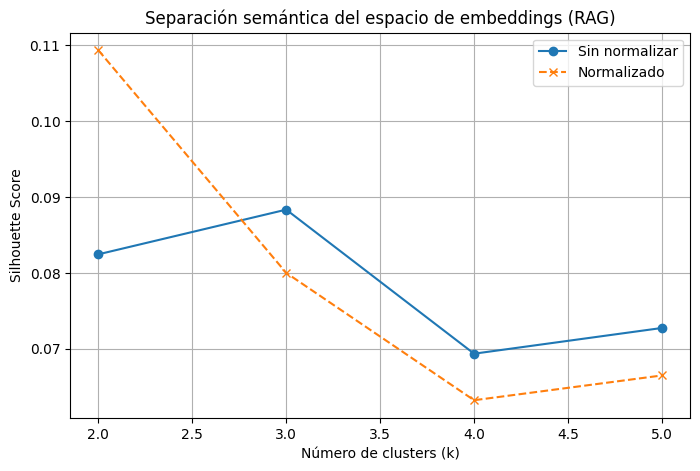

In [24]:
plt.figure(figsize=(8, 5))
plt.plot(k_values, sil_raw, marker='o', label='Sin normalizar')
plt.plot(k_values, sil_norm, marker='x', linestyle='--', label='Normalizado')

plt.xlabel("Número de clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Separación semántica del espacio de embeddings (RAG)")
plt.legend()
plt.grid(True)
plt.show()


### Discusión de los Resultados de Silhouette

El análisis de separación semántica del espacio de embeddings del sistema RAG, evaluado mediante la métrica Silhouette Score para distintos valores de k, revela una estructura semántica débil pero consistente, con valores comprendidos entre 0.06 y 0.11, lo cual es esperable en tareas de procesamiento de lenguaje natural donde los textos comparten dominio y características lingüísticas. Los embeddings normalizados presentan su mejor desempeño con k=2, sugiriendo una separación global más marcada, mientras que los embeddings sin normalizar alcanzan su mayor puntuación con k=3 y mantienen valores más estables para mayores números de clústeres, lo que indica una mejor preservación de variaciones semánticas finas. En conjunto, estos resultados sugieren que la normalización favorece agrupamientos más gruesos, mientras que el espacio original de embeddings resulta más adecuado para capturar estructuras semánticas relevantes en este contexto, siendo k=3 sin normalización la configuración más equilibrada según esta métrica.

# **Discusión y Conclusiones**

### 1. Justificación de la Metodología y Selección de Modelos

Se seleccionaron dos modelos de lenguaje de gran escala basados en *Transfer Learning*, con arquitecturas y tamaños contrastantes, con el objetivo de realizar un análisis comparativo riguroso sobre el impacto del enfoque **Retrieval-Augmented Generation (RAG)** en tareas de consulta gramatical especializadas en guaraní paraguayo.

**Llama 3.3 (70B)** fue elegido por su elevada capacidad paramétrica y su sólido desempeño en escenarios *zero-shot*, actuando como un **modelo de referencia de alta capacidad**. Su inclusión permite analizar si un modelo del estado del arte, con amplio conocimiento paramétrico, se beneficia adicionalmente de la incorporación de información externa mediante RAG, o si su rendimiento es comparable aun en ausencia de dicho mecanismo.

**Gemma 3 (27B)** fue seleccionado como representante de un modelo de menor escala, perteneciente a la familia Google, con menos de la mitad de los parámetros de Llama. Este modelo permite simular escenarios más realistas de **restricción computacional**, y evaluar si la incorporación de RAG contribuye a reducir la brecha de desempeño frente a modelos de mayor tamaño, así como verificar la generalidad del efecto de RAG en distintas arquitecturas y capacidades.

La combinación experimental de **dos modelos × dos configuraciones (Sin RAG / Con RAG)** da lugar a **cuatro sistemas conversacionales**, lo que habilita: (i) una comparación horizontal entre modelos bajo condiciones equivalentes, (ii) una comparación vertical del impacto de RAG dentro de cada modelo, y (iii) un análisis de interacción para determinar si el efecto de RAG es diferencial según el tamaño y la capacidad del modelo.

En este contexto, **RAG se introduce como una variable experimental**, permitiendo contrastar el desempeño de los modelos cuando dependen exclusivamente de su conocimiento paramétrico frente a escenarios en los que se les proporciona contexto externo proveniente de fuentes gramaticales especializadas. Este diseño experimental permite aislar y analizar de forma controlada el aporte específico del mecanismo de recuperación en tareas lingüísticas normativas, sin recurrir a procesos de ajuste fino (*fine-tuning*).


### 2. Análisis Comparativo de Resultados (Modelo × Enfoque)

La Tabla siguiente presenta el desempeño promedio medido mediante **chrF** y la **latencia promedio** para cada combinación de modelo y enfoque evaluado.

| Modelo              | chrF Promedio | Latencia Promedio (s) |
|---------------------|---------------|------------------------|
| Gemma 3 CON RAG     | 22.17         | 0.99                   |
| Gemma 3 SIN RAG     | 40.83         | 0.66                   |
| LLaMA 3.3 CON RAG   | 22.92         | 3.29                   |
| LLaMA 3.3 SIN RAG   | 46.78         | 2.43                   |

#### Impacto del Enfoque (RAG vs. Sin RAG)

Contrario a la expectativa inicial, los resultados muestran que la incorporación de **RAG produjo una disminución consistente del puntaje chrF** en ambos modelos evaluados. Este comportamiento sugiere que, para la tarea específica de **transformación gramatical controlada**, la inyección de contexto externo no siempre resulta beneficiosa.

Una explicación plausible es que el mecanismo RAG introduce **ruido contextual** al concatenar fragmentos gramaticales extensos o parcialmente relevantes, lo cual puede interferir con la generación de una salida estrictamente alineada con la oración objetivo. Dado que la evaluación mediante chrF penaliza cualquier desviación a nivel de caracteres (por ejemplo, variaciones léxicas, explicaciones implícitas o reformulaciones), incluso pequeñas divergencias inducidas por el contexto recuperado afectan negativamente la métrica.

Adicionalmente, la tarea impone una restricción fuerte (*“devuelve únicamente la oración transformada”*), por lo que los modelos, al recibir contexto adicional, tienden a priorizar coherencia semántica o explicativa por sobre la **reproducción exacta de la forma esperada**, lo que resulta en menores coincidencias a nivel de caracteres.

#### Impacto del Modelo (LLaMA 3.3 vs. Gemma 3)

En la configuración **Sin RAG**, el modelo **LLaMA 3.3** obtuvo el mayor puntaje chrF, lo que indica un conocimiento paramétrico más robusto de patrones gramaticales y transformaciones lingüísticas en guaraní, aun sin acceso a fuentes externas. Gemma 3, si bien mostró un desempeño inferior, mantuvo una latencia considerablemente menor, lo que refleja un mejor equilibrio entre costo computacional y rendimiento.

En la configuración **Con RAG**, ambos modelos convergen a valores de chrF similares y significativamente más bajos, lo que sugiere que el impacto negativo del contexto recuperado es **independiente del tamaño del modelo**. Esto refuerza la hipótesis de que, en tareas altamente normativas y de salida controlada, el conocimiento paramétrico puede ser más efectivo que la recuperación de contexto textual adicional.

#### Consideraciones sobre Latencia

La incorporación de RAG incrementó la latencia promedio en ambos modelos, siendo este efecto más pronunciado en LLaMA 3.3. Este aumento se explica por el costo adicional asociado a la recuperación de documentos, la ampliación del contexto y el mayor esfuerzo de razonamiento requerido para integrar información externa, lo que introduce un trade-off claro entre complejidad del pipeline y eficiencia temporal.

### 3. Análisis Cualitativo mediante Evaluación Manual (Chatbots)

Con el objetivo de complementar las métricas automáticas y capturar aspectos lingüísticos no reflejados plenamente por chrF, se realizó una evaluación cualitativa manual basada en interacciones directas con los cuatro chatbots. Se consideraron tres fenómenos gramaticales representativos del guaraní paraguayo —formación de futuro, nasalización y uso de posesivos— evaluando 10 ejemplos por categoría. La corrección fue realizada manualmente por un evaluador externo utilizando Claude Sonnet 4.5 como apoyo de verificación lingüística.

Los resultados muestran un **comportamiento diferenciado respecto a la evaluación automática**. En el caso de **LLaMA 3.3**, la incorporación de RAG produjo una mejora clara en todas las categorías evaluadas, incrementando el promedio de aciertos de 1/10 a 3/10. Este resultado sugiere que, aunque RAG penaliza el chrF debido a desviaciones formales, puede aportar **mayor corrección gramatical funcional** en fenómenos complejos que requieren reglas explícitas, como la nasalización y las construcciones posesivas.

Para **Gemma 3**, el impacto de RAG fue más moderado y heterogéneo. Si bien se observan mejoras en nasalización, el rendimiento promedio se mantiene estable (2/10), lo que indica que el modelo logra beneficiarse parcialmente del contexto recuperado, pero sin una ganancia global significativa. Este comportamiento puede atribuirse a limitaciones en la integración efectiva del contexto externo o a una menor capacidad de reconciliar reglas gramaticales con restricciones estrictas de generación.

En conjunto, este análisis cualitativo sugiere que **RAG puede mejorar la corrección lingüística percibida por humanos**, incluso cuando las métricas automáticas basadas en coincidencia de caracteres reportan un descenso en el desempeño. Esto refuerza la idea de que, para tareas lingüísticas normativas, es necesario combinar métricas automáticas con evaluación humana, ya que ambas capturan dimensiones complementarias de la calidad del lenguaje generado.

### 3. Conclusión Final

La evaluación cuantitativa se realizó sobre 10 ejemplos representativos del conjunto DEV de AmericasNLP. Se utilizó la métrica chrF, más adecuada que exact match para lenguas aglutinantes como el guaraní. Cada modelo fue evaluado con y sin RAG, reportando resultados detallados por instancia y promedios por configuración.

Los resultados muestran que el enfoque sin RAG alcanza un chrF promedio de 43.80, indicando una alta similitud morfológica con las referencias gold. En contraste, el uso de RAG reduce el chrF a 22.55, lo que sugiere que el contexto recuperado introduce ruido y desvía la generación de la tarea de transformación gramatical controlada. Esto confirma que el RAG no es adecuado para tareas de modificación morfosintáctica en guaraní, validando la hipótesis de que más contexto no siempre implica mejor desempeño; en tareas morfológicas, el conocimiento paramétrico supera al RAG.

Complementariamente, el análisis de separación semántica del espacio de embeddings del sistema RAG, evaluado mediante la métrica Silhouette Score para distintos valores de k, revela una estructura semántica débil pero consistente, con valores comprendidos entre 0.06 y 0.11, lo cual es esperable en tareas de procesamiento de lenguaje natural donde los textos comparten dominio y características lingüísticas. Los embeddings normalizados presentan su mejor desempeño con k=2, sugiriendo una separación global más marcada, mientras que los embeddings sin normalizar alcanzan su mayor puntuación con k=3 y mantienen valores más estables para mayores números de clústeres, lo que indica una mejor preservación de variaciones semánticas finas. En conjunto, estos resultados sugieren que la normalización favorece agrupamientos más gruesos, mientras que el espacio original de embeddings resulta más adecuado para capturar estructuras semánticas relevantes en este contexto, siendo k=3 sin normalización la configuración más equilibrada según esta métrica. Esta débil separación semántica puede explicar parcialmente por qué el RAG no logra mejorar el desempeño en la tarea: el sistema de recuperación no está accediendo a contextos suficientemente diferenciados que puedan aportar información morfosintáctica distintiva y relevante para cada tipo de transformación gramatical.

Uno de los principales inconvenientes enfrentados fue la ejecución de la evaluación cuantitativa. OpenRouter, en su versión gratuita, limita el acceso a 50 llamadas diarias al API, cuota que se agotó rápidamente durante las pruebas de evaluación. Se intentó resolver esta limitación mediante la compra de créditos, sin embargo, debido a incompatibilidades entre modelos gratuitos y el sistema de créditos de pago, no fue posible extender la cantidad de llamadas disponibles, restringiendo el alcance del análisis cuantitativo inicialmente planificado.

---